<a href="https://colab.research.google.com/github/malcolmrite-dsi/RockVideoClassifier/blob/main/RockClassifierCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script will show you how to read frames from a video, resize it and sample sub-images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [80]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from pathlib import Path
from PIL import Image
import csv

import pandas as pd
import seaborn as sns

from keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras.models import Model

In [ ]:
def sample_image(img, x, y, win_size, cnn_size):
  h, w, col = img.shape

  delta = int(win_size/2)

  x0 = x - delta 
  x1 = x + delta
  y0 = y - delta
  y1 = y + delta

  '''  if y0 < 0:
      y0 = int(0)
      y1 = int(win_size * 2)
  
  if y1 > h:
      y0 = int(h - win_size * 2)
      y1 = int(h)
  
  if x0 < 0:
      x0 = int(0)
      x1 = int(win_size * 2)
  
  if x1 > w:
      x0 = int(w - win_size * 2)
      x1 = int(w)'''

  img_sample = img[y0:y1, x0:x1]

  # convert to CNN format
  img_cnn = cv2.resize(img_sample, (cnn_size,cnn_size))
  img_cnn = np.ndarray.astype(img_cnn, np.float32)
  img_cnn = np.reshape(img_cnn, (cnn_size, cnn_size, col))

  return img_cnn, [x0,x1,y0,y1]

In [81]:
def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")


In [ ]:
model_path = "/content/drive/My Drive/model_best.h5"
model = keras.models.load_model(model_path)

In [ ]:
predictions = pd.DataFrame(columns=["image","label"])
label_list = ['chip', 'fines', 'lump', 'mixed', 'pellets']

In [82]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_2.mp4"

disk_dir = Path("/content/drive/My Drive/Notifications/bin_2")
disk_dir.mkdir(parents=True, exist_ok=True)

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

contamFlag = 0
notifCount = 0
calmCount = 0
notifications = []

results_g = pd.DataFrame(columns = label_list)

sample_window_size = 100
cnn_img_size = 64

tic = time.process_time()
for frame_num in range(int(N_frames)):
  has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

  if has_img:
    # Images in your trainging set were monochrome
    #img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
    x = 300
    y = 300
    sample, rect = sample_image(img, int(x), int(y), sample_window_size, cnn_img_size)

    # TODO: CLASSIFER CODE HERE
    
    sample = np.expand_dims(sample, axis=0)
    sample = preprocess_input(sample)
    outputs = model.predict(sample)
    labels = outputs.argmax(axis=-1)

    labels = [label_list[i] for i in labels]


    # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED
    if (outputs[0,1] >= 0.9 or outputs[0,3] >= 0.9) and calmCount == 0:
      contamFlag += 1
      if contamFlag == 5:
        notifCount += 1
        notifications.append(frame_num)
        store_single_disk(img, frame_num, notifCount)
    elif contamFlag > 0:
      calmCount += 1
      if calmCount == 20:
        contamFlag = 0
        calmCount = 0

    # COLAB
    # - - - - - - - - - - - - 
    
    clear_output(wait=True)
    #cv2_imshow(img[rect[2]:rect[3], rect[0]:rect[1]]) 
    #cv2.waitKey(1) & 0xff
    print(labels)
    # - - - - - - - - - - - - 

    # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH
    results_g = results_g.append(pd.DataFrame(outputs, columns=label_list))
    

dt = time.process_time() - tic
print(dt, dt/(N_frames)) # Samples per frame should be below 150 ms




['lump']
148.33155604600006 0.10300802503194449


In [83]:
print(notifications)
print(notifCount)

[56, 518, 682, 748, 810, 846, 878, 937, 1064, 1168, 1226, 1286]
12


In [ ]:

results_g

,chip,fines,lump,mixed,pellets
0,0.008672,9.399841e-01,0.026618,0.004765,1.996227e-02
0,0.008672,9.399841e-01,0.026618,0.004765,1.996227e-02
0,0.035505,1.823837e-08,0.048629,0.915866,3.210542e-10
0,0.008672,9.399841e-01,0.026618,0.004765,1.996227e-02
0,0.043584,3.880385e-08,0.081004,0.875413,3.952902e-10
...,...,...,...,...,...
0,0.000696,9.474144e-09,0.913713,0.085591,1.267623e-12
0,0.000866,9.197631e-09,0.892452,0.106682,7.918168e-13
0,0.001458,1.053380e-08,0.864356,0.134186,1.893316e-12
0,0.001662,1.383033e-08,0.903380,0.094958,1.983262e-12


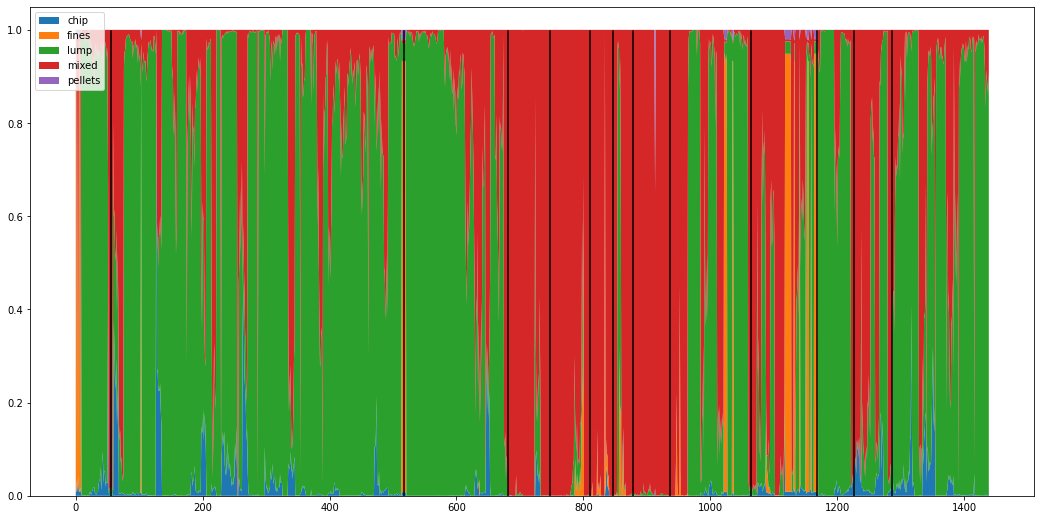

In [84]:

plt.figure(figsize=(18,9))

plt.stackplot(list(range(0, N_frames)), [results_g.chip, results_g.fines , results_g.lump, results_g.mixed, results_g.pellets], labels=label_list,
              )
plt.legend(loc='upper left')
for frame in notifications:
  plt.axvline(x=frame, color = "black", label = 'Notification', ymax = 0.95, markeredgewidth = 3)

plt.show()

In [ ]:
plt.plot(y)

In [ ]:
print(np.reshape(graphArraychip, (len(graphArraychip), 1)))